# Validación de valores NaN en el dataset generado

Este notebook valida la presencia de valores NaN en el dataset generado y proporciona estadísticas sobre su distribución.

In [1]:
# Importaciones necesarias
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import os
import gc

# Configuración de visualización
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)

In [2]:
# Definir la ruta al dataset generado
dataset_path = "/Users/riperez/Conda/anaconda3/doc/precipitation/output/complete_dataset_with_features.nc"

# Verificar que el archivo exista
if os.path.exists(dataset_path):
    print(f"El archivo existe. Tamaño: {os.path.getsize(dataset_path) / (1024*1024):.2f} MB")
else:
    print(f"Error: El archivo {dataset_path} no existe.")

El archivo existe. Tamaño: 19.25 MB


In [3]:
# Cargar el dataset con xarray
try:
    # Cargar con chunks para manejar datasets grandes
    ds = xr.open_dataset(dataset_path, chunks={'time': 20, 'latitude': 100, 'longitude': 100})
    print("Dataset cargado correctamente.")
    print(f"\nDimensiones del dataset:")
    print(ds.dims)
    
    print(f"\nVariables disponibles:")
    for var in ds.data_vars:
        print(f"- {var}: {ds[var].dims}")
        
    # Mostrar algunos metadatos
    print(f"\nMetadatos:")
    for attr_name, attr_value in ds.attrs.items():
        print(f"- {attr_name}: {attr_value}")
except Exception as e:
    print(f"Error al cargar el dataset: {e}")

Dataset cargado correctamente.

Dimensiones del dataset:
FrozenMappingWarningOnValuesAccess({'time': 530, 'latitude': 62, 'longitude': 66})

Variables disponibles:
- total_precipitation: ('time', 'latitude', 'longitude')
- max_daily_precipitation: ('time', 'latitude', 'longitude')
- min_daily_precipitation: ('time', 'latitude', 'longitude')
- daily_precipitation_std: ('time', 'latitude', 'longitude')
- month_sin: ('time', 'latitude', 'longitude')
- month_cos: ('time', 'latitude', 'longitude')
- doy_sin: ('time', 'latitude', 'longitude')
- doy_cos: ('time', 'latitude', 'longitude')
- elevation: ('latitude', 'longitude')
- slope: ('latitude', 'longitude')
- aspect: ('latitude', 'longitude')

Metadatos:
- description: ST-HyMOUNTAIN-Net ready dataset with CHIRPS monthly precipitation and DEM variables
- source: CHIRPS v2.0 & DEM Boyacá
- author: Your Name
- created_at: 2025-04-24 16:41:54


/var/folders/83/c6n8lktn4qx_fwp7ksllkkhn0dhtn2/T/ipykernel_13252/3435835055.py:4: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 20. This could degrade performance. Instead, consider rechunking after loading.
  ds = xr.open_dataset(dataset_path, chunks={'time': 20, 'latitude': 100, 'longitude': 100})


In [4]:
# Función para validar NaN en el dataset
def validate_nans(dataset):
    """Valida la presencia de NaN en todas las variables del dataset."""
    results = {}
    
    print("Analizando valores NaN en cada variable...")
    for var_name in dataset.data_vars:
        # Contar NaN en la variable completa
        nan_count = dataset[var_name].isnull().sum().compute().item()
        total_elements = dataset[var_name].size
        nan_percentage = (nan_count / total_elements) * 100 if total_elements > 0 else 0
        
        results[var_name] = {
            'nan_count': nan_count,
            'total_elements': total_elements,
            'nan_percentage': nan_percentage
        }
        
        print(f"Variable: {var_name}")
        print(f"  - Elementos totales: {total_elements:,}")
        print(f"  - Valores NaN: {nan_count:,} ({nan_percentage:.2f}%)")
    
    return results

In [5]:
# Analizar NaN en el dataset
try:
    nan_results = validate_nans(ds)
except Exception as e:
    print(f"Error al analizar valores NaN: {e}")

Analizando valores NaN en cada variable...
Variable: total_precipitation
  - Elementos totales: 2,168,760
  - Valores NaN: 0 (0.00%)
Variable: max_daily_precipitation
  - Elementos totales: 2,168,760
  - Valores NaN: 0 (0.00%)
Variable: min_daily_precipitation
  - Elementos totales: 2,168,760
  - Valores NaN: 0 (0.00%)
Variable: daily_precipitation_std
  - Elementos totales: 2,168,760
  - Valores NaN: 0 (0.00%)
Variable: month_sin
  - Elementos totales: 2,168,760
  - Valores NaN: 0 (0.00%)
Variable: month_cos
  - Elementos totales: 2,168,760
  - Valores NaN: 0 (0.00%)
Variable: total_precipitation
  - Elementos totales: 2,168,760
  - Valores NaN: 0 (0.00%)
Variable: max_daily_precipitation
  - Elementos totales: 2,168,760
  - Valores NaN: 0 (0.00%)
Variable: min_daily_precipitation
  - Elementos totales: 2,168,760
  - Valores NaN: 0 (0.00%)
Variable: daily_precipitation_std
  - Elementos totales: 2,168,760
  - Valores NaN: 0 (0.00%)
Variable: month_sin
  - Elementos totales: 2,168,760


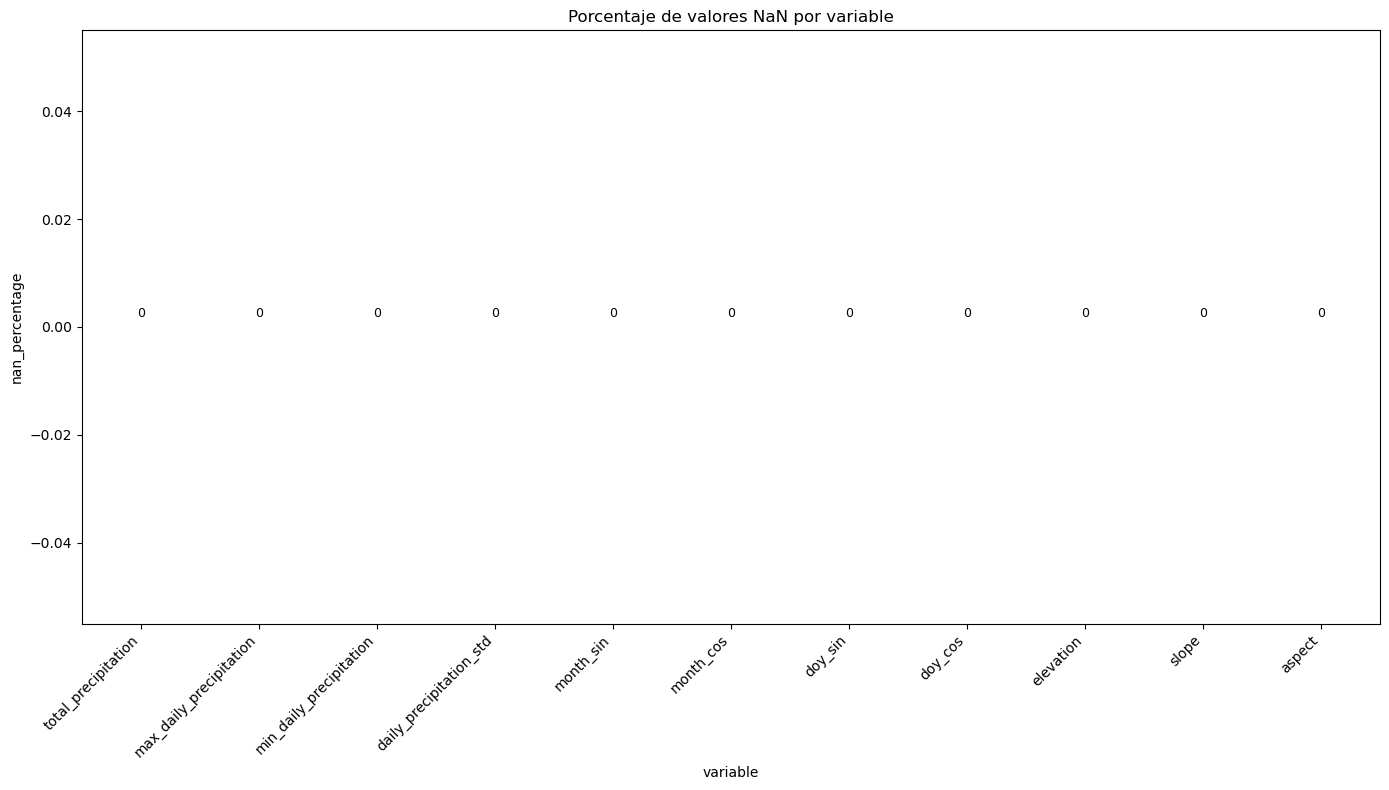

In [6]:
# Visualizar distribución de NaN
try:
    # Crear dataframe con resultados para visualización
    nan_df = pd.DataFrame([
        {
            'variable': var_name,
            'nan_percentage': info['nan_percentage'],
            'nan_count': info['nan_count'],
            'valid_count': info['total_elements'] - info['nan_count']
        } for var_name, info in nan_results.items()
    ])
    
    # Ordenar por porcentaje de NaN
    nan_df = nan_df.sort_values('nan_percentage', ascending=False)
    
    # Visualizar como gráfico de barras
    plt.figure(figsize=(14, 8))
    ax = sns.barplot(x='variable', y='nan_percentage', data=nan_df)
    plt.title('Porcentaje de valores NaN por variable')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    
    # Añadir etiquetas con el recuento sobre cada barra
    for i, p in enumerate(ax.patches):
        ax.annotate(f"{nan_df.iloc[i]['nan_count']:,}",
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom', fontsize=9, rotation=0, xytext=(0, 5),
                    textcoords='offset points')
    
    plt.show()
except Exception as e:
    print(f"Error al visualizar resultados: {e}")

In [7]:
# Analizar la distribución espacial de NaN para una variable con alto porcentaje de NaN
try:
    if nan_df.nan_percentage.max() > 0:
        # Identificar la variable con mayor porcentaje de NaN
        var_with_most_nans = nan_df.iloc[0]['variable']
        print(f"Analizando distribución espacial de NaN para: {var_with_most_nans}")
        
        # Si la variable tiene dimensión temporal, usar el primer paso de tiempo
        if 'time' in ds[var_with_most_nans].dims:
            nan_map = ds[var_with_most_nans].isel(time=0).isnull()
            title = f"Mapa de NaN para {var_with_most_nans} (primer paso de tiempo)"
        else:
            nan_map = ds[var_with_most_nans].isnull()
            title = f"Mapa de NaN para {var_with_most_nans}"
        
        plt.figure(figsize=(10, 8))
        nan_map.plot(cmap='binary')
        plt.title(title)
        plt.show()
    else:
        print("No hay variables con valores NaN para mostrar en un mapa.")
except Exception as e:
    print(f"Error al analizar distribución espacial: {e}")

No hay variables con valores NaN para mostrar en un mapa.


In [8]:
# Verificar si hay valores inválidos (infinitos) además de NaN
print("Verificando valores infinitos...")
for var_name in ds.data_vars:
    try:
        # Contabilizar valores infinitos
        if np.issubdtype(ds[var_name].dtype, np.number):
            inf_pos_count = (ds[var_name] == np.inf).sum().compute().item()
            inf_neg_count = (ds[var_name] == -np.inf).sum().compute().item()
            
            if inf_pos_count > 0 or inf_neg_count > 0:
                print(f"Variable {var_name}:")
                print(f"  - Infinitos positivos: {inf_pos_count:,}")
                print(f"  - Infinitos negativos: {inf_neg_count:,}")
    except Exception as e:
        print(f"Error al verificar infinitos en {var_name}: {e}")

Verificando valores infinitos...


## Identificar Valores NaN

## Análisis de Correlación Temporal - Comportamiento Bimodal en Colombia

Colombia presenta un patrón bimodal de precipitaciones con dos temporadas lluviosas al año, generalmente en abril-mayo y octubre-noviembre. Este análisis examina las correlaciones entre variables climáticas y la precipitación considerando este patrón bimodal característico del país.

In [ ]:
# Análisis del comportamiento bimodal de precipitaciones en Colombia
try:
    # Verificar si la variable de precipitación existe en el dataset
    precip_vars = [var for var in ds.data_vars if 'precipitation' in var or 'precip' in var]
    
    if len(precip_vars) > 0:
        print(f"Variables de precipitación encontradas: {precip_vars}")
        precip_var = 'total_precipitation' if 'total_precipitation' in precip_vars else precip_vars[0]
        
        # Convertir a DataFrame para facilitar el análisis
        if 'time' in ds.dims:
            # Extraer serie temporal promediando espacialmente
            print(f"Extrayendo serie temporal de {precip_var}...")
            precip_series = ds[precip_var].mean(dim=['latitude', 'longitude']).to_dataframe()
            
            # Asegurar que el índice sea datetime
            if not isinstance(precip_series.index, pd.DatetimeIndex):
                precip_series = precip_series.reset_index()
                precip_series['time'] = pd.to_datetime(precip_series['time'])
                precip_series = precip_series.set_index('time')
            
            # Extraer mes del índice de tiempo
            precip_series['month'] = precip_series.index.month
            
            # Calcular la precipitación promedio por mes
            monthly_avg = precip_series.groupby('month')[precip_var].mean().reset_index()
            
            # Visualizar el patrón bimodal
            plt.figure(figsize=(12, 6))
            sns.lineplot(data=monthly_avg, x='month', y=precip_var, marker='o', linewidth=2)
            plt.title(f'Patrón Bimodal de Precipitación en Colombia - Promedio Mensual de {precip_var}')
            plt.xlabel('Mes')
            plt.ylabel('Precipitación promedio')
            plt.xticks(range(1, 13), ['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic'])
            plt.grid(True, alpha=0.3)
            plt.show()
            
            # Definir temporadas bimodales de Colombia
            precip_series['temporada'] = 'Transición'
            # Primera temporada lluviosa (abril-mayo)
            precip_series.loc[precip_series['month'].isin([4, 5]), 'temporada'] = 'Lluvia 1'
            # Segunda temporada lluviosa (octubre-noviembre)
            precip_series.loc[precip_series['month'].isin([10, 11]), 'temporada'] = 'Lluvia 2'
            # Primera temporada seca (diciembre-febrero)
            precip_series.loc[precip_series['month'].isin([12, 1, 2]), 'temporada'] = 'Seca 1'
            # Segunda temporada seca (julio-agosto)
            precip_series.loc[precip_series['month'].isin([7, 8]), 'temporada'] = 'Seca 2'
            
            # Análisis de correlación entre variables por temporada bimodal
            print("\nAnalizando correlación entre variables por temporada bimodal...")
            
            # Seleccionar variables numéricas para correlación
            numeric_vars = [var for var in ds.data_vars 
                          if np.issubdtype(ds[var].dtype, np.number) 
                          and 'time' in ds[var].dims 
                          and var != precip_var][:5]  # Limitar a 5 variables para mantener la visualización clara
            
            if numeric_vars:
                # Crear DataFrame con variables seleccionadas
                df_corr = precip_series[[precip_var, 'temporada', 'month']].copy()
                
                # Añadir las otras variables numéricas
                for var in numeric_vars:
                    print(f"Procesando variable: {var}")
                    var_series = ds[var].mean(dim=['latitude', 'longitude']).to_dataframe()
                    df_corr = df_corr.join(var_series[var])
                
                # Calcular correlación por temporada bimodal
                seasons = ['Lluvia 1', 'Lluvia 2', 'Seca 1', 'Seca 2', 'Transición']
                corr_by_season = {}
                
                for season in seasons:
                    season_df = df_corr[df_corr['temporada'] == season]
                    if not season_df.empty:
                        corr = [season_df[var].corr(season_df[precip_var]) for var in numeric_vars]
                        corr_by_season[season] = corr
                
                # Visualizar correlaciones por temporada bimodal
                plt.figure(figsize=(14, 8))
                x = np.arange(len(numeric_vars))
                width = 0.15
                
                for i, (season, corrs) in enumerate(corr_by_season.items()):
                    plt.bar(x + (i - 2) * width, corrs, width, label=season)
                
                plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
                plt.xlabel('Variables')
                plt.ylabel(f'Correlación con {precip_var}')
                plt.title(f'Correlación con Precipitación por Temporada Bimodal en Colombia')
                plt.xticks(x, numeric_vars, rotation=45, ha='right')
                plt.legend(loc='best')
                plt.grid(True, axis='y', alpha=0.3)
                plt.tight_layout()
                plt.show()
                
                # Análisis de significancia de las correlaciones
                print("\nTest de significancia de correlaciones por temporada:")
                for season in seasons:
                    season_df = df_corr[df_corr['temporada'] == season]
                    if not season_df.empty:
                        print(f"\nTemporada: {season}")
                        for var in numeric_vars:
                            corr = season_df[var].corr(season_df[precip_var])
                            # Calcular p-valor para correlación de Pearson
                            from scipy import stats
                            _, p_value = stats.pearsonr(season_df[var].dropna(), season_df[precip_var].dropna())
                            sig = '***' if p_value < 0.001 else '**' if p_value < 0.01 else '*' if p_value < 0.05 else 'ns'
                            print(f"  {var}: r = {corr:.3f} (p = {p_value:.4f}) {sig}")
            else:
                print("No se encontraron suficientes variables numéricas para análisis de correlación.")
        else:
            print("No se encontró dimensión temporal en el dataset para analizar patrones bimodales.")
    else:
        print("No se encontraron variables de precipitación en el dataset.")
except Exception as e:
    print(f"Error en análisis de comportamiento bimodal: {e}")
    import traceback
    traceback.print_exc()

In [ ]:
# Mapa de precipitación por temporada bimodal
try:
    if 'time' in ds.dims and len(precip_vars) > 0:
        # Convertir tiempos a objetos datetime para trabajar con ellos
        times = pd.to_datetime(ds.time.values)
        
        # Crear DataArrays para cada temporada
        lluvia1_mask = (pd.DatetimeIndex(times).month.isin([4, 5]))
        lluvia2_mask = (pd.DatetimeIndex(times).month.isin([10, 11]))
        seca1_mask = (pd.DatetimeIndex(times).month.isin([12, 1, 2]))
        seca2_mask = (pd.DatetimeIndex(times).month.isin([7, 8]))
        
        # Calcular promedios por temporada
        lluvia1_avg = ds[precip_var].isel(time=lluvia1_mask).mean(dim='time', skipna=True)
        lluvia2_avg = ds[precip_var].isel(time=lluvia2_mask).mean(dim='time', skipna=True)
        seca1_avg = ds[precip_var].isel(time=seca1_mask).mean(dim='time', skipna=True)
        seca2_avg = ds[precip_var].isel(time=seca2_mask).mean(dim='time', skipna=True)
        
        # Visualizar mapas de precipitación por temporada
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle(f'Distribución Espacial de {precip_var} por Temporada Bimodal', fontsize=16)
        
        # Primera temporada de lluvias (abril-mayo)
        im1 = lluvia1_avg.plot(ax=axes[0, 0], cmap='Blues', add_colorbar=True)
        axes[0, 0].set_title('Temporada de Lluvias 1 (Abr-May)')
        
        # Segunda temporada de lluvias (octubre-noviembre)
        im2 = lluvia2_avg.plot(ax=axes[0, 1], cmap='Blues', add_colorbar=True)
        axes[0, 1].set_title('Temporada de Lluvias 2 (Oct-Nov)')
        
        # Primera temporada seca (diciembre-febrero)
        im3 = seca1_avg.plot(ax=axes[1, 0], cmap='Blues', add_colorbar=True)
        axes[1, 0].set_title('Temporada Seca 1 (Dic-Feb)')
        
        # Segunda temporada seca (julio-agosto)
        im4 = seca2_avg.plot(ax=axes[1, 1], cmap='Blues', add_colorbar=True)
        axes[1, 1].set_title('Temporada Seca 2 (Jul-Ago)')
        
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()
        
        # Calcular y visualizar la diferencia entre temporadas de lluvia
        diff_lluvia = lluvia2_avg - lluvia1_avg
        plt.figure(figsize=(10, 8))
        diff_lluvia.plot(cmap='RdBu_r', center=0)
        plt.title('Diferencia de Precipitación: Temporada de Lluvias 2 - Temporada de Lluvias 1')
        plt.show()
except Exception as e:
    print(f"Error al crear mapas de temporada bimodal: {e}")
    import traceback
    traceback.print_exc()